In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches
from scarches.models import TRANVAE
from scarches.dataset import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [4]:
label_ratio = 0.7

In [5]:
condition_key = 'condition'
cell_type_key = 'final_annotation'
target_conditions = ['Sun', 'Freytag']


tranvae_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [6]:
adata_all = sc.read(os.path.expanduser(f'~/Documents/benchmarking_datasets/Immune_ALL_human_wo_villani_rqr_normalized_hvg.h5ad'))
adata = adata_all.raw.to_adata()
adata = remove_sparsity(adata)
source_adata = adata[~adata.obs.study.isin(target_conditions)].copy()
target_adata = adata[adata.obs.study.isin(target_conditions)].copy()
source_conditions = source_adata.obs[condition_key].unique().tolist()
source_labels = source_adata.obs[cell_type_key].unique().tolist()

In [7]:
source_adata

AnnData object with n_obs × n_vars = 12186 × 4000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'condition'

In [8]:
print(len(source_labels))
source_labels

14


['CD16+ Monocytes',
 'HSPCs',
 'CD8+ T cells',
 'Erythrocytes',
 'CD10+ B cells',
 'Plasmacytoid dendritic cells',
 'Monocyte progenitors',
 'CD20+ B cells',
 'Monocyte-derived dendritic cells',
 'Plasma cells',
 'Erythroid progenitors',
 'Megakaryocyte progenitors',
 'NK cells',
 'CD14+ Monocytes']

In [9]:
target_adata

AnnData object with n_obs × n_vars = 8336 × 4000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'condition'

In [10]:
target_adata.obs[cell_type_key].unique().tolist()

['CD8+ T cells',
 'NKT cells',
 'NK cells',
 'CD20+ B cells',
 'Megakaryocyte progenitors',
 'Plasmacytoid dendritic cells',
 'CD16+ Monocytes',
 'CD4+ T cells',
 'Monocyte-derived dendritic cells']

In [11]:
idx = np.arange(len(source_adata))
np.random.shuffle(idx)
n_labeled = int(label_ratio*len(source_adata))
labeled_ind = idx[:n_labeled]

In [12]:
print(source_adata.obs[condition_key][labeled_ind].unique().tolist())
print(source_adata.obs[condition_key][~labeled_ind].unique().tolist())
print(source_adata.obs[cell_type_key][labeled_ind].unique().tolist())
print(source_adata.obs[cell_type_key][~labeled_ind].unique().tolist())

['Oetjen_A', 'Oetjen_P', '10X', 'Oetjen_U']
['10X', 'Oetjen_U', 'Oetjen_P', 'Oetjen_A']
['CD10+ B cells', 'CD8+ T cells', 'CD14+ Monocytes', 'Monocyte-derived dendritic cells', 'Erythrocytes', 'CD20+ B cells', 'Plasmacytoid dendritic cells', 'NK cells', 'Monocyte progenitors', 'HSPCs', 'Erythroid progenitors', 'Megakaryocyte progenitors', 'Plasma cells', 'CD16+ Monocytes']
['CD14+ Monocytes', 'CD16+ Monocytes', 'Monocyte-derived dendritic cells', 'Plasma cells', 'CD20+ B cells', 'Erythrocytes', 'HSPCs', 'CD8+ T cells', 'Megakaryocyte progenitors', 'NK cells', 'Erythroid progenitors', 'Monocyte progenitors', 'Plasmacytoid dendritic cells', 'CD10+ B cells']


In [13]:
tranvae = scarches.models.TRANVAE(
    adata=source_adata,
    condition_key=condition_key,
    cell_type_key=cell_type_key,
    labeled_indices=labeled_ind,
    hidden_layer_sizes=[128, 128],
    use_mmd=False
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 4
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 4
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 4000 



In [14]:
tranvae.model.condition_encoder

{'Oetjen_A': 0, 'Oetjen_P': 1, 'Oetjen_U': 2, '10X': 3}

In [15]:
tranvae.model.cell_type_encoder

{'CD16+ Monocytes': 0,
 'HSPCs': 1,
 'CD8+ T cells': 2,
 'Erythrocytes': 3,
 'CD10+ B cells': 4,
 'Plasmacytoid dendritic cells': 5,
 'Monocyte progenitors': 6,
 'CD20+ B cells': 7,
 'Monocyte-derived dendritic cells': 8,
 'Plasma cells': 9,
 'Erythroid progenitors': 10,
 'Megakaryocyte progenitors': 11,
 'NK cells': 12,
 'CD14+ Monocytes': 13}

In [16]:
tranvae.train(
    n_epochs=tranvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    eta=1000,
    tau=0,
)

 |█████---------------| 28.2%  - epoch_loss: 4681.64 - epoch_trvae_loss: 4648.67 - epoch_classifier_loss:   32.97 - epoch_unlabeled_loss:    0.02 - epoch_labeled_loss:    0.02 - val_loss: 5109.16 - val_trvae_loss: 5006.73 - val_classifier_loss:  102.43 - val_unlabeled_loss:    0.03 - val_labeled_loss:    0.0726
ADJUSTED LR
 |██████--------------| 32.2%  - epoch_loss: 4588.69 - epoch_trvae_loss: 4563.08 - epoch_classifier_loss:   25.61 - epoch_unlabeled_loss:    0.01 - epoch_labeled_loss:    0.01 - val_loss: 5095.60 - val_trvae_loss: 5002.88 - val_classifier_loss:   92.72 - val_unlabeled_loss:    0.03 - val_labeled_loss:    0.06
ADJUSTED LR
 |██████--------------| 33.6%  - epoch_loss: 4648.42 - epoch_trvae_loss: 4623.45 - epoch_classifier_loss:   24.97 - epoch_unlabeled_loss:    0.01 - epoch_labeled_loss:    0.01 - val_loss: 5120.60 - val_trvae_loss: 5024.05 - val_classifier_loss:   96.55 - val_unlabeled_loss:    0.04 - val_labeled_loss:    0.06
Stopping early: no improvement of more th

In [17]:
adata_latent = sc.AnnData(tranvae.get_latent())
adata_latent.obs['celltype'] = source_adata.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = source_adata.obs[condition_key].tolist()
adata_latent.obs['predictions'] = tranvae.classify()

In [18]:
dir_path = os.path.expanduser(f'~/Documents/aaa_dev_mars/pbmc_testing/')
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

... storing 'celltype' as categorical
... storing 'batch' as categorical
... storing 'predictions' as categorical


[<AxesSubplot:title={'center':'batch'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'celltype'}, xlabel='UMAP1', ylabel='UMAP2'>]

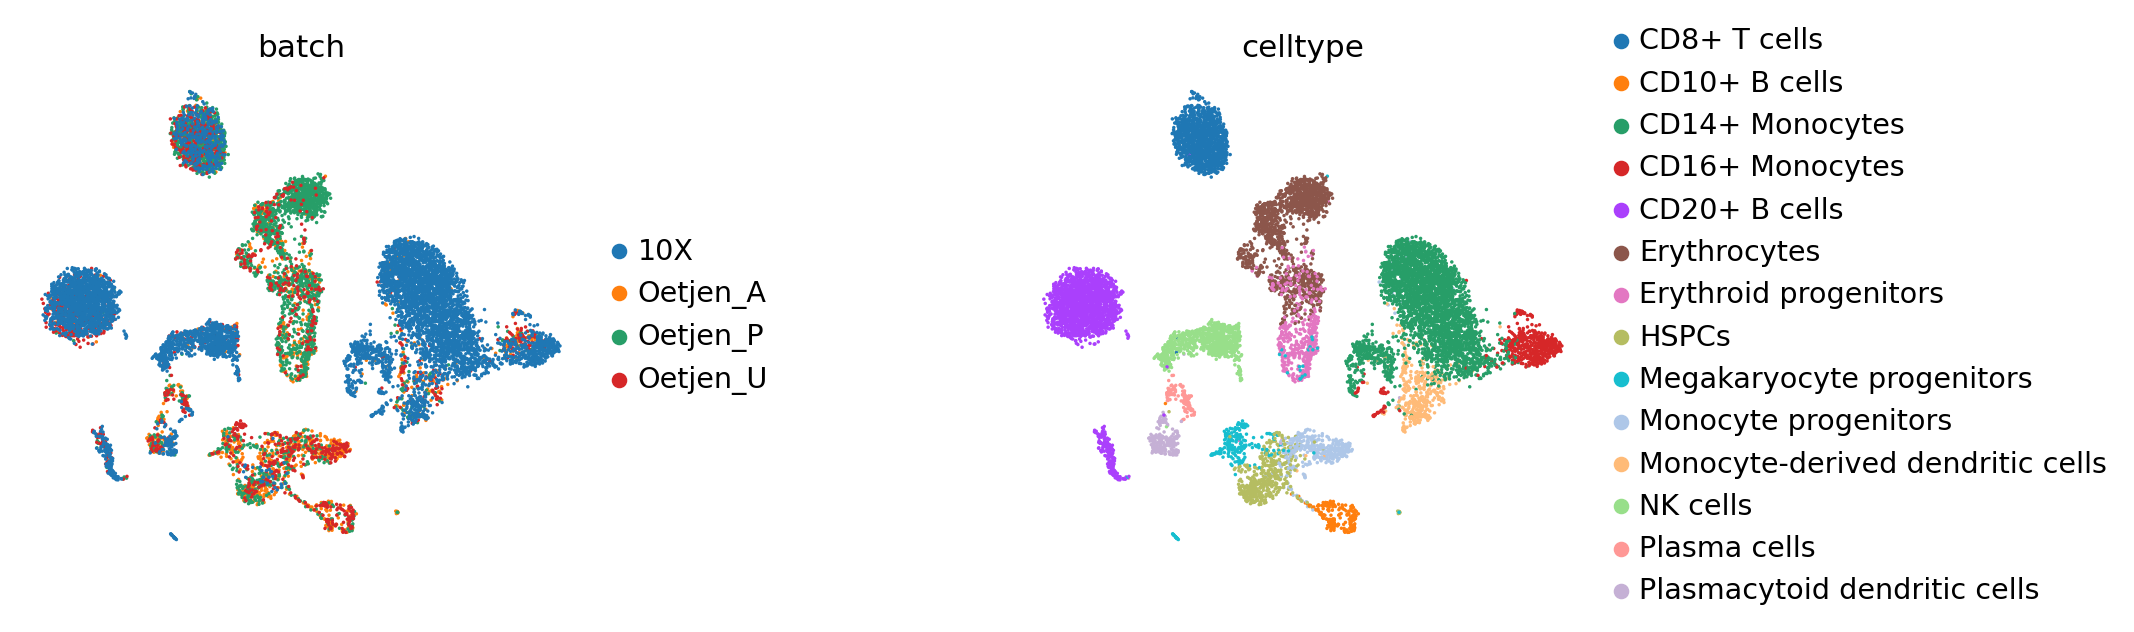

In [19]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
adata_latent.write_h5ad(filename=f'{dir_path}reference_data.h5ad')
sc.pl.umap(adata_latent,
           color=['batch', 'celltype'],
           frameon=False,
           wspace=0.6,
           show=False
           )

In [20]:
print("Acc: {}".format(np.mean(adata_latent.obs.predictions == adata_latent.obs.celltype)))

Acc: 0.9494501887411784


In [21]:
landmarks_labeled = tranvae.model.landmarks_labeled.cpu().numpy()
landmarks_unlabeled = tranvae.model.landmarks_unlabeled.cpu().numpy()
print(landmarks_labeled)
print(landmarks_unlabeled)

[[ 1.29 -0.45 -0.04  0.26 -0.53 -0.17 -1.67  0.31 -1.21 -0.92]
 [ 0.8  -0.49 -1.33  0.58  0.41  0.24 -1.36  0.91  0.49 -0.41]
 [ 0.29 -0.15  0.17  1.84  0.01  0.09 -0.61  0.23 -0.33 -0.65]
 [ 0.    0.13 -1.2   0.36 -0.92  0.24 -0.73 -0.33  0.05 -0.71]
 [ 0.79 -0.53 -1.34  0.51  0.42  0.29 -1.33  0.89  0.58 -0.4 ]
 [ 1.18 -0.16 -0.56  0.11 -0.4   0.67  0.48  0.37 -0.09 -0.58]
 [ 0.82 -0.5  -1.34  0.54  0.38  0.22 -1.43  0.86  0.5  -0.4 ]
 [ 0.62 -0.22  1.09 -0.63 -0.03  0.41 -0.2   0.29 -0.8  -0.38]
 [ 1.29 -0.38 -0.07  0.19 -0.47 -0.1  -1.69  0.35 -1.25 -0.92]
 [ 1.18 -0.2  -0.48  0.12 -0.47  0.62  0.5   0.31 -0.05 -0.57]
 [-0.03  0.15 -1.21  0.33 -0.9   0.29 -0.75 -0.29  0.04 -0.71]
 [ 0.74 -0.43 -1.38  0.54  0.35  0.22 -1.34  0.88  0.52 -0.44]
 [ 1.2  -0.13 -0.53  0.18 -0.46  0.61  0.54  0.36 -0.05 -0.6 ]
 [ 1.29 -0.36 -0.05  0.23 -0.5  -0.16 -1.7   0.34 -1.22 -0.92]]
[[-0.29 -0.26  0.39 -0.46  0.09  0.77 -1.8   0.28  0.2  -0.67]
 [ 0.8  -0.49 -1.35  0.54  0.4   0.24 -1.38  0.89  0.5

In [22]:
extended_latent = adata_latent.X.copy()
extended_latent = np.concatenate((extended_latent, landmarks_labeled), axis=0)
extended_latent = np.concatenate((extended_latent, landmarks_unlabeled), axis=0)

extended_latent_labels = adata_latent.obs['celltype'].tolist()
landmark_names=[]
for i in range(landmarks_labeled.shape[0]):
    landmark_names.append(f'Landmark{i}')
    
extended_latent_labels+=landmark_names   
extended_latent_labels+=landmark_names
    
extended_latent_batches = adata_latent.obs['batch'].tolist()
extended_latent_batches += landmarks_labeled.shape[0]*['Landmarks_labeled']
extended_latent_batches += landmarks_unlabeled.shape[0]*['Landmarks_unlabeled']

extended_latent = sc.AnnData(extended_latent)
extended_latent.obs['celltype'] = extended_latent_labels
extended_latent.obs['batch'] = extended_latent_batches
extended_latent

AnnData object with n_obs × n_vars = 12214 × 10
    obs: 'celltype', 'batch'

In [23]:
sc.pp.neighbors(extended_latent, n_neighbors=8)
sc.tl.leiden(extended_latent)
sc.tl.umap(extended_latent)

... storing 'celltype' as categorical
... storing 'batch' as categorical


<AxesSubplot:title={'center':'celltype'}, xlabel='UMAP1', ylabel='UMAP2'>

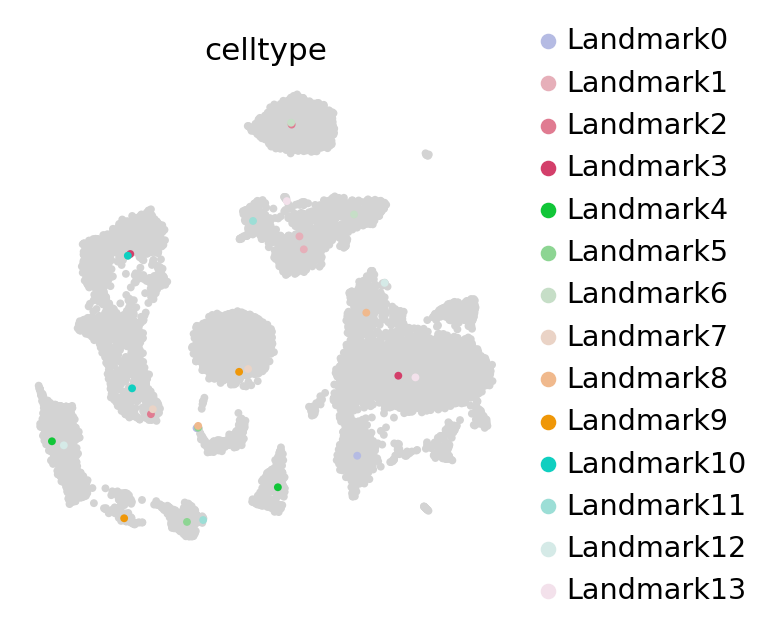

In [24]:
sc.pl.umap(extended_latent,
           color=['celltype'],
           groups=landmark_names,
           frameon=False,
           wspace=0.6,
           show=False,
           size=50
           )

<AxesSubplot:title={'center':'batch'}, xlabel='UMAP1', ylabel='UMAP2'>

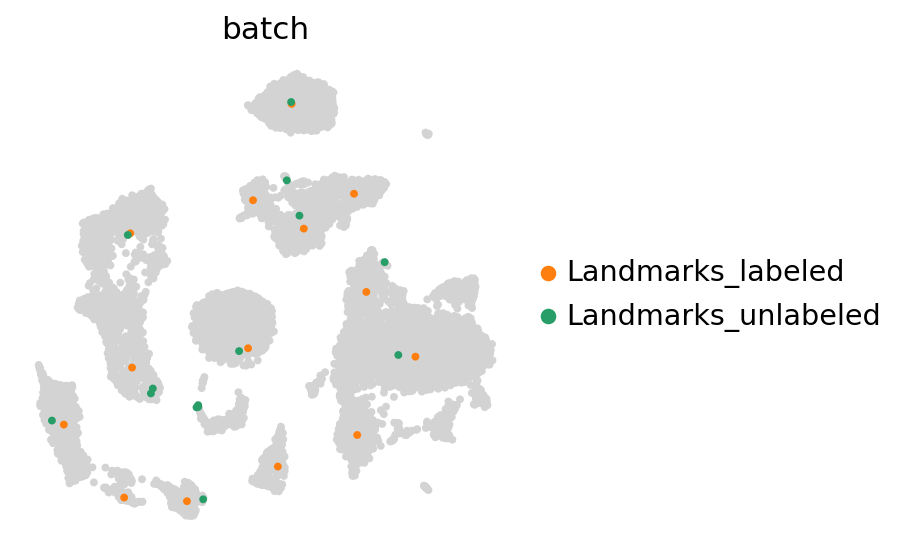

In [25]:
landmark_batches = ['Landmarks_labeled', 'Landmarks_unlabeled']
sc.pl.umap(extended_latent,
           color=['batch'],
           frameon=False,
           groups=landmark_batches,
           wspace=0.6,
           show=False,
           size=50
           )

<AxesSubplot:title={'center':'celltype'}, xlabel='UMAP1', ylabel='UMAP2'>

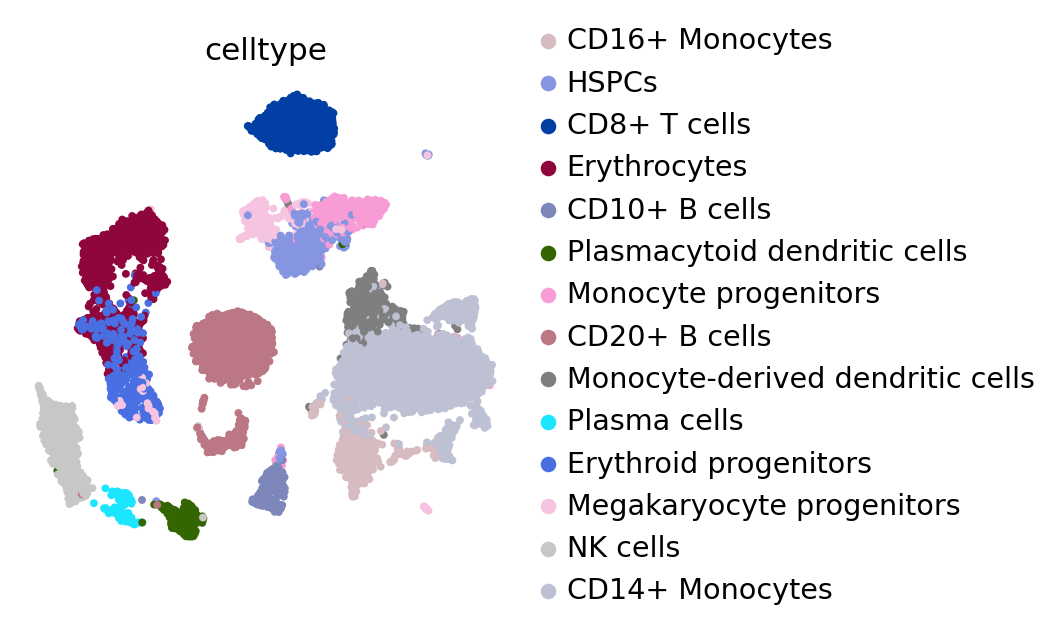

In [26]:
celltypes = adata_latent.obs['celltype'].unique().tolist()
sc.pl.umap(extended_latent,
           color=['celltype'],
           frameon=False,
           groups=celltypes,
           wspace=0.6,
           show=False,
           size=50
           )

In [27]:
ref_path = f'{dir_path}reference_model/'
tranvae.save(ref_path, overwrite=True)

In [28]:
new_tranvae = scarches.models.TRANVAE.load(
    f'{dir_path}reference_model/',
    source_adata
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 4
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 4
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 4000 



In [29]:
print(new_tranvae.model.landmarks_labeled)

[[ 1.29 -0.45 -0.04  0.26 -0.53 -0.17 -1.67  0.31 -1.21 -0.92]
 [ 0.8  -0.49 -1.33  0.58  0.41  0.24 -1.36  0.91  0.49 -0.41]
 [ 0.29 -0.15  0.17  1.84  0.01  0.09 -0.61  0.23 -0.33 -0.65]
 [ 0.    0.13 -1.2   0.36 -0.92  0.24 -0.73 -0.33  0.05 -0.71]
 [ 0.79 -0.53 -1.34  0.51  0.42  0.29 -1.33  0.89  0.58 -0.4 ]
 [ 1.18 -0.16 -0.56  0.11 -0.4   0.67  0.48  0.37 -0.09 -0.58]
 [ 0.82 -0.5  -1.34  0.54  0.38  0.22 -1.43  0.86  0.5  -0.4 ]
 [ 0.62 -0.22  1.09 -0.63 -0.03  0.41 -0.2   0.29 -0.8  -0.38]
 [ 1.29 -0.38 -0.07  0.19 -0.47 -0.1  -1.69  0.35 -1.25 -0.92]
 [ 1.18 -0.2  -0.48  0.12 -0.47  0.62  0.5   0.31 -0.05 -0.57]
 [-0.03  0.15 -1.21  0.33 -0.9   0.29 -0.75 -0.29  0.04 -0.71]
 [ 0.74 -0.43 -1.38  0.54  0.35  0.22 -1.34  0.88  0.52 -0.44]
 [ 1.2  -0.13 -0.53  0.18 -0.46  0.61  0.54  0.36 -0.05 -0.6 ]
 [ 1.29 -0.36 -0.05  0.23 -0.5  -0.16 -1.7   0.34 -1.22 -0.92]]
